# Importing Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Loading data

In [3]:
# show full columns if needed
pd.set_option("display.max_columns", 200)

# load your merged dataset 
df = pd.read_csv("/Users/mariatirado/citibike_2022_weather/data/processed/citibike_trips_weather_merged_2022.csv")

df.head()

,date,total_trips,PRCP,TMAX,TMIN
0,2022-01-01,20428,19.3,13.9,10.0
1,2022-01-02,43009,1.0,15.6,3.9
2,2022-01-03,33189,0.0,3.9,-4.3
3,2022-01-04,36842,0.0,2.2,-6.0
4,2022-01-05,34230,6.1,8.9,0.0


In [4]:
sns.set_theme(style="whitegrid", palette="Set2")

# Bar chart: Top 20 starting stations

In [7]:
trips_2022 = pd.read_csv("data/processed/citibike_weather_2022.csv")

/var/folders/zj/m82l3gps79nc61v2flg2kkzr0000gn/T/ipykernel_3056/4083186195.py:1: DtypeWarning: Columns (0: start_station_id, 1: end_station_id) have mixed types. Specify dtype option on import or set low_memory=False.
  trips_2022 = pd.read_csv("data/processed/citibike_weather_2022.csv")


/var/folders/zj/m82l3gps79nc61v2flg2kkzr0000gn/T/ipykernel_3056/385062144.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


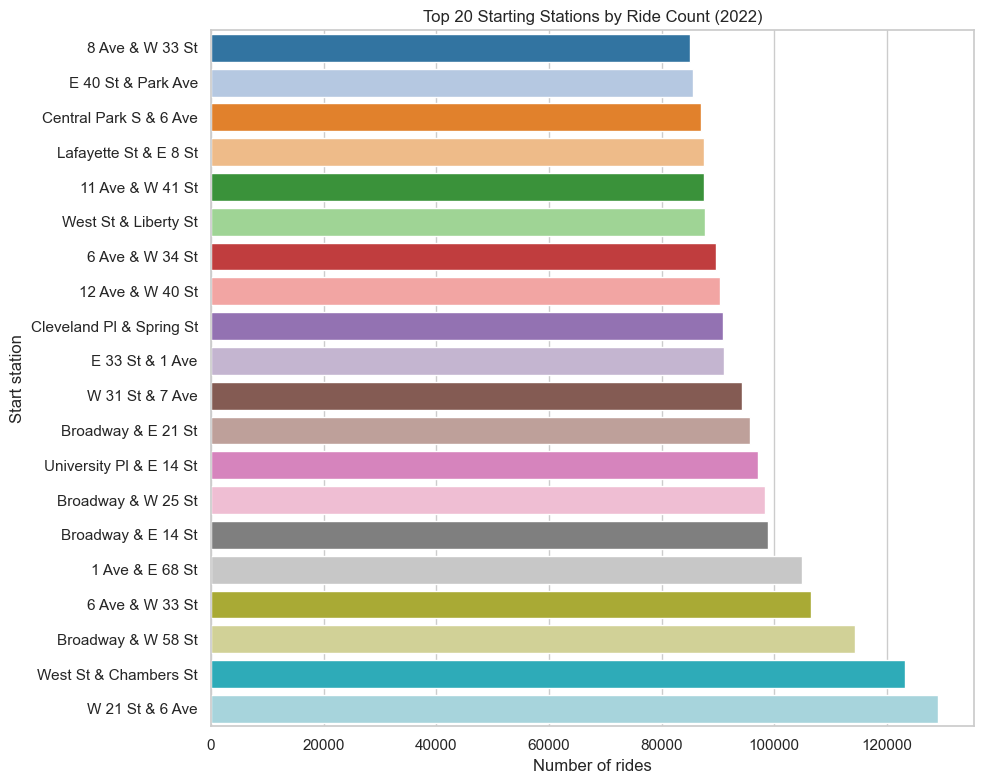

In [8]:
top20 = (
    trips_2022["start_station_name"]
    .dropna()
    .value_counts()
    .head(20)
    .sort_values(ascending=True)
)

plt.figure(figsize=(10, 8))


sns.barplot(
    x=top20.values,
    y=top20.index,
    palette=sns.color_palette("tab20", n_colors=20)
)

plt.title("Top 20 Starting Stations by Ride Count (2022)")
plt.xlabel("Number of rides")
plt.ylabel("Start station")
plt.tight_layout()
plt.show()

# Comment
my global palette didn’t have enough distinct colors for 20 categories, so I used tab20 for this plot only.

# Dual-axis seasonality line chart

In [14]:
# trips file (already merged rides)
trips_2022 = pd.read_csv("data/processed/citibike_weather_2022.csv", low_memory=False)

# make sure date is datetime 
trips_2022["date"] = pd.to_datetime(trips_2022["date"], errors="coerce")

# build daily trips (now definitely datetime)
daily_trips = (
    trips_2022.groupby("date")
    .size()
    .reset_index(name="total_trips"))

# weather file
weather_clean = pd.read_csv("data/processed/noaa_lga_daily_2022.csv")
weather_clean["date"] = pd.to_datetime(weather_clean["date"], errors="coerce")

# PROVE dtypes 
print("daily_trips date dtype:", daily_trips["date"].dtype)
print("weather_clean date dtype:", weather_clean["date"].dtype)

# merge
daily_weather = daily_trips.merge(weather_clean, on="date", how="left")

daily_weather.head()

daily_trips date dtype: datetime64[us]
weather_clean date dtype: datetime64[us]


,date,total_trips,PRCP,TMAX,TMIN
0,2022-01-01,20428,19.3,13.9,10.0
1,2022-01-02,43009,1.0,15.6,3.9
2,2022-01-03,33189,0.0,3.9,-4.3
3,2022-01-04,36842,0.0,2.2,-6.0
4,2022-01-05,34230,6.1,8.9,0.0


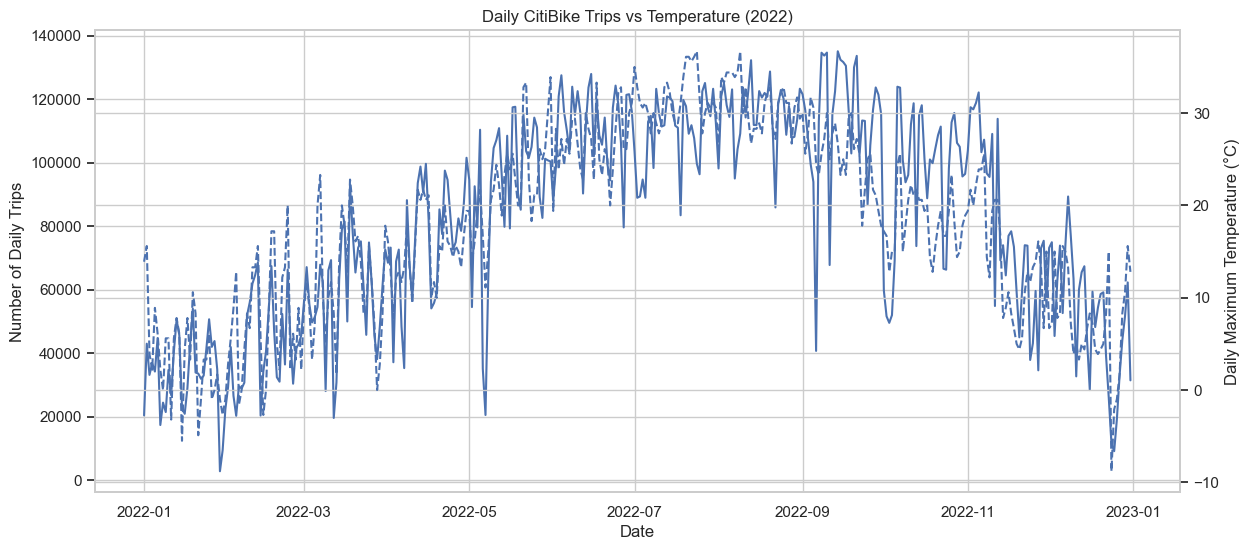

In [15]:
sns.set_theme(style="whitegrid")

fig, ax1 = plt.subplots(figsize=(14,6))

#  FIRST AXIS (RIDES) 
sns.lineplot(
    data=daily_weather,
    x="date",
    y="total_trips",
    ax=ax1
)

ax1.set_ylabel("Number of Daily Trips")
ax1.set_xlabel("Date")
ax1.set_title("Daily CitiBike Trips vs Temperature (2022)")

#  SECOND AXIS (TEMPERATURE) 
ax2 = ax1.twinx()

sns.lineplot(
    data=daily_weather,
    x="date",
    y="TMAX",
    ax=ax2,
    linestyle="--"
)

ax2.set_ylabel("Daily Maximum Temperature (°C)")

plt.show()

# Comments

The dual-axis line chart shows that daily ride volume closely follows temperature patterns throughout the year. Ridership increases significantly during warmer months and declines during colder periods, indicating strong seasonality in bike usage. This suggests that weather, particularly temperature, is a major driver of demand. CitiBike could use weather forecasts to anticipate demand fluctuations and proactively rebalance bikes and station capacity.

#  Box plot with categorical variable

In [16]:
trips_2022["started_at"] = pd.to_datetime(trips_2022["started_at"], errors="coerce")
trips_2022["ended_at"] = pd.to_datetime(trips_2022["ended_at"], errors="coerce")

trips_2022["trip_min"] = (trips_2022["ended_at"] - trips_2022["started_at"]).dt.total_seconds() / 60

df_box = trips_2022[(trips_2022["trip_min"] > 0) & (trips_2022["trip_min"] < 120)]

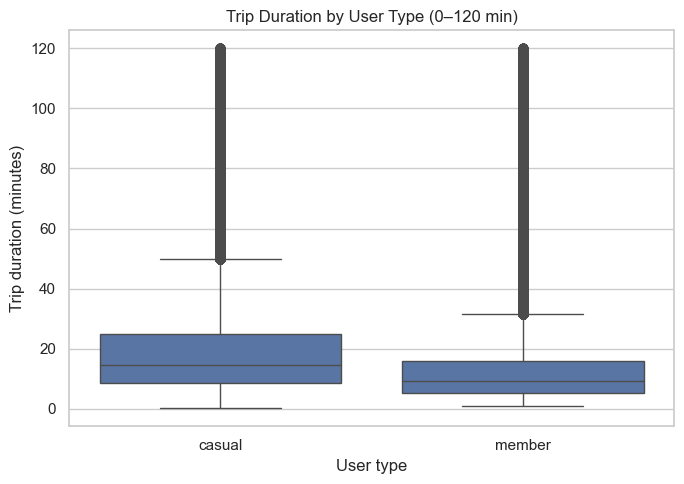

In [17]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=df_box, x="member_casual", y="trip_min")
plt.title("Trip Duration by User Type (0–120 min)")
plt.xlabel("User type")
plt.ylabel("Trip duration (minutes)")
plt.tight_layout()
plt.show()

# Comments 

Casual users tend to take longer trips than members. The median trip duration for casual riders is higher, and the spread of the data is wider, which means their ride times vary more. In contrast, members usually have shorter and more consistent trips. This suggests that members mainly use CitiBike for commuting or daily transportation, while casual riders are more likely using it for leisure or tourism.

# FacetGrid to deepen the analysis

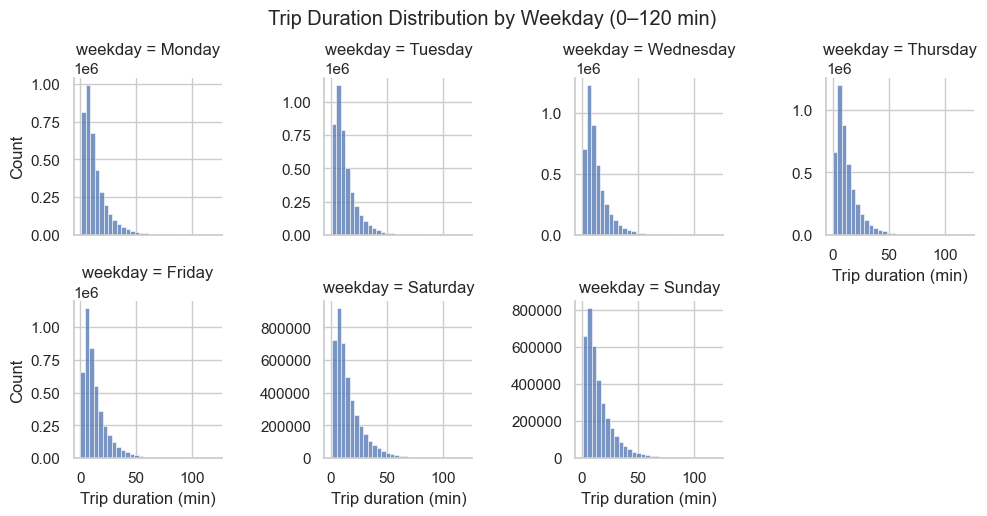

In [18]:
df_box["weekday"] = pd.to_datetime(df_box["started_at"]).dt.day_name()
weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
df_box["weekday"] = pd.Categorical(df_box["weekday"], categories=weekday_order, ordered=True)

g = sns.FacetGrid(df_box, col="weekday", col_wrap=4, height=2.5, sharex=True, sharey=False)
g.map_dataframe(sns.histplot, x="trip_min", bins=30)
g.set_axis_labels("Trip duration (min)", "Count")
g.fig.suptitle("Trip Duration Distribution by Weekday (0–120 min)", y=1.03)
plt.show()

# Comments

Most rides are short (around 5–20 minutes) on all days of the week. However, weekdays show more concentration of short trips, while weekends (Saturday and Sunday) have relatively more longer rides. This indicates that people mainly use CitiBike for commuting during the week and for leisure activities on weekends.